# Determine paralleism of z-axis to spindle axis of RA-2200

Use straightness measurements of Wecan Sample 1 measured on opposite sides to separate part and machine profiles.  
This is analogous to straightedge reversal  as described in:

Evans, Chris J., Robert J. Hocken, and W. Tyler Estler. “Self-Calibration: Reversal, Redundancy, Error Separation, and [`]Absolute Testing’.” CIRP Annals - Manufacturing Technology 45, no. 2 (1996): 617–34. https://doi.org/10.1016/S0007-8506(07)60515-0.



In [1]:
from pathlib import Path
import numpy as np
import pandas as pd

In [2]:
DATA_DIR = Path(r"C:\Users\e.howick\gits\ls_RA2200\spindle_parallesism_2021-05\data\raw")

In [3]:
files = sorted(list(DATA_DIR.glob("Straight*.txt")))
files

[WindowsPath('C:/Users/e.howick/gits/ls_RA2200/spindle_parallesism_2021-05/data/raw/straightness_S1_opp.txt'),
 WindowsPath('C:/Users/e.howick/gits/ls_RA2200/spindle_parallesism_2021-05/data/raw/straightness_S1_outer.txt'),
 WindowsPath('C:/Users/e.howick/gits/ls_RA2200/spindle_parallesism_2021-05/data/raw/straightness_S2_opp_wire.txt'),
 WindowsPath('C:/Users/e.howick/gits/ls_RA2200/spindle_parallesism_2021-05/data/raw/straightness_S2_outer_wire.txt')]

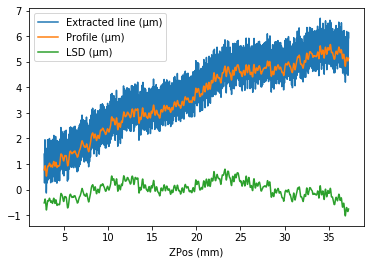

In [4]:
S1_opp = pd.read_csv(files[0], skiprows=18, header=0, skipfooter=1, engine='python')
S1_opp = S1_opp.drop(['Curve No.', 'Delete Flag'], axis=1)
S1_opp.plot('ZPos (mm)', ['Extracted line (µm)', 'Profile (µm)', 'LSD (µm)']);

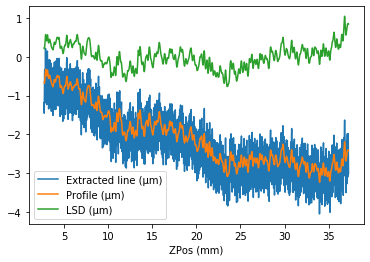

In [5]:
S1_out = pd.read_csv(files[1], skiprows=18, header=0, skipfooter=1, engine='python')
S1_out = S1_out.drop(['Curve No.', 'Delete Flag'], axis=1)
S1_out.plot('ZPos (mm)', ['Extracted line (µm)', 'Profile (µm)', 'LSD (µm)']);

In [6]:
# interpolate onto same index and combine dfs
start = max(S1_opp.loc[0, 'ZPos (mm)'], S1_out.loc[0, 'ZPos (mm)'])
stop  = min(S1_opp.loc[S1_opp.index[-1] , 'ZPos (mm)'], S1_out.loc[S1_out.index[-1] , 'ZPos (mm)'])
interval = 0.004
zpos = np.arange(start, stop, interval)
df1 = S1_opp.set_index('ZPos (mm)')
df1 = df1.reindex(df1.index | zpos).interpolate(method='index', limit_direction='both').loc[zpos]
df2 = S1_out.set_index('ZPos (mm)')
df2 = df2.reindex(df2.index | zpos).interpolate(method='index', limit_direction='both').loc[zpos]
S1 = pd.concat([df1, df2], axis=1)
S1.columns = [c + '_opp' for c in df1.columns] + [c + '_out' for c in df2.columns]
S1

,Point No._opp,Extracted line (µm)_opp,Profile (µm)_opp,LSD (µm)_opp,Point No._out,Extracted line (µm)_out,Profile (µm)_out,LSD (µm)_out
2.7545,2.0,1.1596,0.7722,-0.5179,1.0,-1.1817,-0.6546,0.2273
2.7585,3.0,0.9841,0.7757,-0.5149,2.0,-1.3559,-0.6623,0.2198
2.7625,4.0,0.8333,0.7792,-0.5119,3.0,-1.4521,-0.6687,0.2137
2.7665,5.0,0.6747,0.7829,-0.5087,4.0,-1.3923,-0.6737,0.2090
2.7705,6.0,0.5330,0.7870,-0.5052,5.0,-1.2090,-0.6773,0.2056
...,...,...,...,...,...,...,...,...
37.2305,8621.0,5.3638,5.1084,-0.7877,8620.0,-2.2672,-2.4127,0.8457
37.2345,8622.0,5.5978,5.1157,-0.7809,8621.0,-2.3712,-2.4146,0.8441
37.2385,8623.0,5.8773,5.1225,-0.7746,8622.0,-2.4895,-2.4161,0.8428
37.2425,8624.0,6.1113,5.1287,-0.7690,8623.0,-2.6078,-2.4173,0.8419


In [7]:
# the signs chosen to match directions given by wire taped to surface
S1['machine'] = (S1['Extracted line (µm)_out'] + S1['Extracted line (µm)_opp'])/2.0
S1['part'] = (S1['Extracted line (µm)_out'] - S1['Extracted line (µm)_opp'])/2.0
S1['machine filtered'] = (S1['Profile (µm)_out'] + S1['Profile (µm)_opp'])/2.0
S1['part filtered'] = (S1['Profile (µm)_out'] - S1['Profile (µm)_opp'])/2.0

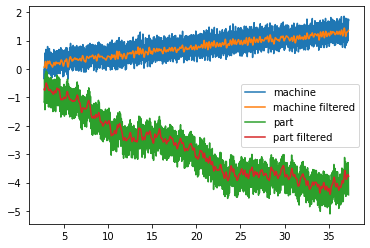

In [8]:
S1.plot(y=['machine', 'machine filtered','part', 'part filtered']);

The machine profile is straight as expected and a similar magnitude to error seen when cylindrical square was measured both ways up.  
Also the part was shown to have a smaller diameter at height of 35 mm than at 5 mm by cylindricity measurements. THis is confirmed by above separation.

In [9]:
d = np.polyfit(S1.index, S1['machine filtered'], 1)
d, d[0]*35

(array([0.03231842, 0.11532339]), 1.1311447026431831)

This gives 0.032 µm/mm of slope between spindle axis and z-axis. Giving a 1.13 µm error over 35 mm.

# Repeat with wire taped to surface

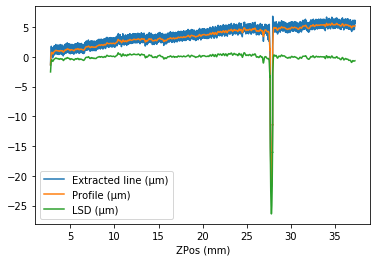

In [10]:
S1_opp = pd.read_csv(files[2], skiprows=18, header=0, skipfooter=1, engine='python')
S1_opp = S1_opp.drop(['Curve No.', 'Delete Flag'], axis=1)
S1_opp.plot('ZPos (mm)', ['Extracted line (µm)', 'Profile (µm)', 'LSD (µm)']);

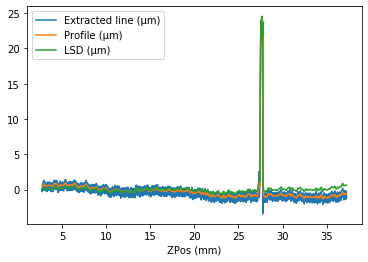

In [11]:
S1_out = pd.read_csv(files[3], skiprows=18, header=0, skipfooter=1, engine='python')
S1_out = S1_out.drop(['Curve No.', 'Delete Flag'], axis=1)
S1_out.plot('ZPos (mm)', ['Extracted line (µm)', 'Profile (µm)', 'LSD (µm)']);

In [12]:
# interpolate onto same index and combine dfs
start = max(S1_opp.loc[0, 'ZPos (mm)'], S1_out.loc[0, 'ZPos (mm)'])
stop  = min(S1_opp.loc[S1_opp.index[-1] , 'ZPos (mm)'], S1_out.loc[S1_out.index[-1] , 'ZPos (mm)'])
interval = 0.004
zpos = np.arange(start, stop, interval)
df1 = S1_opp.set_index('ZPos (mm)')
df1 = df1.reindex(df1.index | zpos).interpolate(method='index', limit_direction='both').loc[zpos]
df2 = S1_out.set_index('ZPos (mm)')
df2 = df2.reindex(df2.index | zpos).interpolate(method='index', limit_direction='both').loc[zpos]
S1 = pd.concat([df1, df2], axis=1)
S1.columns = [c + '_opp' for c in df1.columns] + [c + '_out' for c in df2.columns]

In [13]:
S1['machine'] = (S1['Extracted line (µm)_out'] + S1['Extracted line (µm)_opp'])/2.0
S1['part'] = (S1['Extracted line (µm)_out'] - S1['Extracted line (µm)_opp'])/2.0
S1['machine filtered'] = (S1['Profile (µm)_out'] + S1['Profile (µm)_opp'])/2.0
S1['part filtered'] = (S1['Profile (µm)_out'] - S1['Profile (µm)_opp'])/2.0

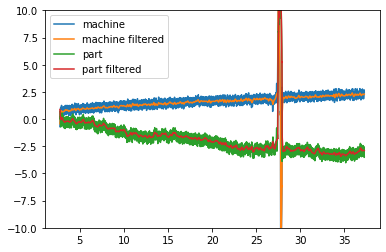

In [14]:
S1.plot(y=['machine', 'machine filtered','part', 'part filtered'], ylim=(-10, 10));

The wire is not entirely removed from both profiles. But signs are shown to be correct.